In [ ]:
import AeroBDSM
import numpy as np
from numpy import rad2deg as deg
from numpy import deg2rad as rad
from numpy import sin as sin
from numpy import cos as cos
from numpy import exp as exp
import matplotlib.pyplot as plt

#Ввод
pi = np.pi
d_mid = 0.178
d_nos_r = 0.178
S_mid = pi * (d_mid**2/4)

#korp
l_nos = 0.47
#l_korm = .225
l_korp_cil = 3.906 - 0.47 #3.160 - l_nos #- l_korm
L = 3.906 #Характерная длина ЛА ~ полная длина

lambda_Nos = l_nos / d_mid
lambda_Cil = l_korp_cil / d_mid
lambda_F = 3.16 / d_mid
#lambda_Korm = l_korm / S_mid
x_t_bar = 0.

#rul
c_r = .004 #толщина профиля
b_b_r = .272 #бортовая хорда
b_k_r = .172 #концевая хорда
c_bar_kr = c_r/b_b_r #относительная толщина профиля

l_kr = .604 #размах консолей руля
l_pr = l_kr+d_nos_r #полный размах рулей
S_kr = ((b_b_r+b_k_r)*l_kr/2) #площадь консолей руля в плане
lambda_kr = l_kr**2 / S_kr #удлинение консолей руля (нес. пов-ти)

d_bar_r = d_nos_r / l_pr #относительный диаметр корпуса

khi_05_kr = 0.510 # 22 град 1 минут в радианах; определено графически
dzeta_kr = b_k_r / b_b_r #обратное сужение консолей руля

x_OVR = 1.562 #расстояние от носа до оси вращения рулей
#kryl
c_k = .05 #толщина профиля
b_b_k = 1.025#бортовая хорда
b_k_k = .263 #концевая хорда
c_bar_kk = c_k/b_b_k #относительная толщина профиля
b_0_k = 1.590

l_kk = .54 #размах консолей крыла
l_pk = l_kk+d_mid #полный размах крыла
S_kk = ((b_b_k+b_k_k)*l_kk/2) #площадь консолей крыла в плане
lambda_kk = l_kk**2 / S_kk #удлинение консолей крыла (нес. пов-ти)

d_bar_k = d_mid / l_pk #относительный диаметр корпуса

khi_05_kk = 0.420 # 24 град 36 минут в радианах; определено графически на упрощённом крыле
dzeta_kk = b_k_k / b_b_k #обратное сужение консолей крыла

S = (b_0_k+b_k_k)*l_pk/2
S_F = S_mid / S
S_1 = S_kr / S
S_2 = S_kk / S

#Дополнительные геометрические параметры
L_1 = 1.559 #расстояние от носика корпуса до середины бортовой хорды консолей
L_A = 2.335 #расстояние от задней точки средней аэродинамической хорды
b_A_r = 225.5 * 10**-3 #средняя аэродинамическая хорда (САХ) (руля)
b_A_k = .791 #средняя аэродинамическая хорда (САХ) (оперения)
x_A_kr = 1.447 #координата начала САХ консолей (руля) (измерялась относительно консоли)
x_A_kk = 3.198 #координата начала САХ консолей (оперения) (измерялась относительно консоли)
x_b_r = 1.424 # координата начала бортовой хорды рулей
x_b_k = 2.969 # координата начала бортовой хорды крыльев
x_c_pl_F = 1.650 #Точка приложения второй, нелинейной части приблизительно совпадает с центром тяжести площади S* бок
S_bok = np.pi * d_mid**2 /4 #Площадь фюзеляжа в плане

F_f = pi*d_mid*(.84175/2*1.05 + l_korp_cil) #площадь обтекаемой пов-и корпуса (с примерной площадью оживальной (параболической) носовой части)

W_nos = 1 / 3 * pi * d_mid**2 / 4 * l_nos * 1.05 #примерный объём носовой части
#Предварительные расчёты
F_L_XB = 1.0
F_1_L_XB = 0.9876

xi_nos = (0.6 + 0.4 * (1 - np.exp(-0.5*L_1 / d_mid)))

Kaa_r_ = 1 + 3*d_bar_r - (d_bar_r*(1 - d_bar_r)) * dzeta_kr #Каа* для рулей
kaa_r_ = (1 + 0.41 * d_bar_r)**2 * (Kaa_r_ / (1 + d_bar_r)**2) #каа* для рулей (консолей)

Kaa_k_ = 1 + 3*d_bar_k - (d_bar_k*(1 - d_bar_k)) * dzeta_kk #Kaa* для крыла
kaa_k_ = (1 + 0.41 * d_bar_k)**2 * (Kaa_k_ / (1 + d_bar_k)**2) #каа* для крыла (консолей)

k_d0_r_ = kaa_r_**2 / Kaa_r_

eta_c_r = AeroBDSM.get_sigma_c_Prf(c_bar_kr, x_t_bar)
eta_c_k = AeroBDSM.get_sigma_c_Prf(c_bar_kk, x_t_bar)
#Относительная эф-ть ОУ (поворотное оперение)
#khi_r = 0.4273, cos ~= 0.9101059...
#к-т k_щ = .95 ... 1 (M > 1.4) (= .99)
n = 0.9
A = lambda x: np.sign(x**2 - 1) * np.sqrt(abs(x**2 - 1))
Si = lambda x: 1/(1+np.exp(-x))
def calc(alpha, delta1, M, a_sound, nyu, x_t):
    #Ввод углов в градусах
    a = alpha
    d1 = delta1
    #Перевод в радианы
    alpha = rad(a)
    delta1 = rad(d1)
    
    ### Расчёт производных по углу атаки
    V = M*a_sound
    
    #Расчёт по y
    #к-ты торможения
    kappa_q1 = AeroBDSM.get_kappa_q_Nos_Con(M, 4).Value #kappa_q1 = kappa_q_Nos
    M1 = M * kappa_q1**.5
    kappa_q2 = kappa_q1 * AeroBDSM.get_kappa_q_IsP(M1, L_A, b_A_r).Value
    M2 = M * kappa_q2**.5
    
    #korp
    c_y1_ParCil_alpha = AeroBDSM.get_c_y_alpha_NosCil_Par(M, lambda_Nos,lambda_Cil).Value #1/rad
    #kryl
    c_y1_IsK_alpha = AeroBDSM.get_c_y_alpha_IsP(M2, lambda_kk, c_bar_kk, khi_05_kk, dzeta_kk).Value #1/rad
    #rul
    c_y1_IsR_alpha = AeroBDSM.get_c_y_alpha_IsP(M1, lambda_kr, c_bar_kr, khi_05_kr, dzeta_kr).Value #1/rad
    
    #Коэффициенты интерференции и угол скоса
    #rul
    
    delta_sr_r = (0.093 / (V*L_1 / nyu)**0.2) * (L_1 / d_nos_r) * (1 + .4 * M1 + .147 * M1**2 -.006 * M1**3)
    etha_kr = 1 / dzeta_kr
    xi_ps = (1 - ((2*d_bar_r**2)/(1-d_bar_r**2))*delta_sr_r) * (1 - ((d_bar_r * (etha_kr-1)) / ((1-d_bar_r)*(etha_kr+1)))*delta_sr_r)
    
    Kaa_r = (kaa_r_ + (Kaa_r_ - kaa_r_)*F_L_XB)*AeroBDSM.get_sigma_f_M(M1, x_t_bar).Value*xi_nos*xi_ps
    kaa_r = kaa_r_ * AeroBDSM.get_sigma_f_M(M1, x_t_bar).Value*xi_nos*xi_ps
    
    #kryl
    
    delta_sr_k = (0.093 / (V*L_1 / nyu)**0.2) * (L_1 / d_mid) * (1 + .4 * M2 + .147 * M2**2 -.006 * M2**3)
    etha_kk = 1 / dzeta_kk
    xi_ps = (1 - ((2*d_bar_k**2)/(1-d_bar_k**2))*delta_sr_k) * (1 - ((d_bar_k * (etha_kk-1)) / ((1-d_bar_k)*(etha_kk+1)))*delta_sr_k)
    
    Kaa_k = (kaa_k_ + (Kaa_k_ - kaa_k_)*F_L_XB)*AeroBDSM.get_sigma_f_M(M2, x_t_bar).Value*xi_nos*xi_ps
    kaa_k = kaa_k_ * AeroBDSM.get_sigma_f_M(M2, x_t_bar).Value*xi_nos*xi_ps
    
    #угол скоса
    z_v_bar_r = AeroBDSM.get_bar_z_v(M1, lambda_kr, khi_05_kr, dzeta_kr).Value
    z_v_r = .5 * (d_nos_r + z_v_bar_r*(l_pr-d_nos_r))
    i_v = AeroBDSM.get_i_v(dzeta_kk, d_mid, l_pk, 0, z_v_r).Value
    
    #psi_eps = AeroBDSM.get_psi_eps(M1, 0, 0, 0, 0, z_v_r, 0, 2.2, d_mid, .2075, dzeta_kk, b_b_k, 0.79)
    
    eps_sr_alpha = ((57.3 / (2 * pi)) * (i_v / z_v_bar_r) * (l_kr / l_kk) * (rad(c_y1_IsR_alpha)  / lambda_kr) * (kaa_r / Kaa_k)) #deg
    
    #c_y1_alpha
    c_y1_alpha = deg(rad(c_y1_ParCil_alpha) * S_F + rad(c_y1_IsR_alpha) * Kaa_r * kappa_q1 * S_1 + rad(c_y1_IsK_alpha) * Kaa_k * (1 - eps_sr_alpha) * kappa_q2 * S_2) #1/rad
    
    ### Расчёт производных по УГЛАМ ОТКЛОНЕНИЯ ОУ
    #к-ты интерференции
    #rul

    xi_ps = ((1 - d_bar_r * (1 + delta_sr_r)) * (1 - ((etha_kr - 1) / (etha_kr + 1 - 2*d_bar_r)) * d_bar_r * (1 + delta_sr_r))) / ((1 - d_bar_r)*(1 - ((etha_kr - 1) / (etha_kr + 1 - 2*d_bar_r)) * d_bar_r))
    
    k_d0_r = k_d0_r_ * xi_ps * AeroBDSM.get_sigma_f_M(M1, x_t_bar).Value
    K_d0_r = (k_d0_r_ + (kaa_r_ - k_d0_r_) * F_L_XB) * xi_ps * AeroBDSM.get_sigma_f_M(M1, x_t_bar).Value
    
    #к-т нормальной силы по углу управления
    c_y1_delta1 = c_y1_IsR_alpha*K_d0_r*n #1/rad
    #угол скоса потока
    eps_sr_delta1 = ((57.3 / (2 * pi)) * (i_v / z_v_bar_r) * (l_kr / l_kk) * (rad(c_y1_IsR_alpha) / lambda_kr) * (k_d0_r / Kaa_k)) #deg
    
    
    
    #Расчёт по x
    #korp
    c_x0_Nos_Par = AeroBDSM.get_c_x0_p_Nos_Par(M, lambda_Nos).Value
    
    Re = V*L / nyu
    
    cf = AeroBDSM.get_c_f0(Re, x_t_bar).Value
    
    c_x0_tr =  cf * (F_f/S_mid)
    
    #c_x0_korm = 0.0
    
    if M <= .723672:
        c_x0_dn = np.log(1.410839 + 1.0432458*A(M) + 1.167756*(A(M))**2 + 0.43818533*(A(M))**3)
    elif M <= .949985:
        c_x0_dn = np.exp(-1.1994635 + 4.1244161*A(M) + 5.4425535*(A(M))**2 + 2.6464556*(A(M))**3)
    elif M <= 1.045254:
        c_x0_dn = np.log(1508.25 - 6119.1935*1/M + 9304.258*1/(M**2) -6277.8414*1/(M**3) + 1585.749*1/(M**4))
    elif M <= 1.335822:
        c_x0_dn = np.exp(-78.55781+249.63042*M-302.51885*M**2 +162.4847*M**3 -32.690523*M**4)
    elif M <= 3.74289:
        c_x0_dn = np.tan(4.6685604-15.483104*Si(M)+18.393009*(Si(M))**2 -7.5350128*(Si(M))**3)
    elif M > 3.74289:
        c_x0_dn = 1.43/(M**2) - .772/(M**2) * (1 - .011*M**2)**3.5
    
    c_x0_F = c_x0_tr + c_x0_Nos_Par + c_x0_dn
    if M >= 1.05:
        #rul
        c_x0_p_r = 2 * cf * eta_c_r
        c_x0_w_r = AeroBDSM.get_c_x0_w_IsP_Rmb(M1, c_bar_kr, dzeta_kr, khi_05_kr, lambda_kr).Value
        c_x0_r = c_x0_p_r + c_x0_w_r
        
        #kryl
        c_x0_p_k = 2 * cf * eta_c_k
        c_x0_w_k = AeroBDSM.get_c_x0_w_IsP_Rmb(M2, c_bar_kk, dzeta_kk, khi_05_kk, lambda_kk).Value
        c_x0_k = c_x0_p_k + c_x0_w_k
    else:
        #rul
        c_x0_p_r = 2 * cf * eta_c_r
        c_x0_r = c_x0_p_r
        
        #kryl
        c_x0_p_k = 2 * cf * eta_c_k
        c_x0_k = c_x0_p_k
    c_x0 = 1.05 * (c_x0_F * S_F + c_x0_r * kappa_q1 * (2 * S_1) + c_x0_k * kappa_q2 * (2 * S_2))
    
    zeta = AeroBDSM.get_sigma_cp_Nos_Par(M, lambda_Nos)
    #ksi = 0 # - к-т реализации подсасывающей силы
    #c_xi_F = ((57.3*rad(c_y1_ParCil_alpha) + 2*zeta) * (a / 57.3)**2) #малые углы
    
    #Фокусы
    delta_x_F = AeroBDSM.get_Delta_bar_x_Falpha_NosCil(M, lambda_Nos, lambda_Cil)
    x_Fa_NosCil = l_nos - W_nos / S_F + delta_x_F
    x_Fa_F = 1 / rad(c_y1_ParCil_alpha) * (rad(c_y1_ParCil_alpha) * x_Fa_NosCil)
    
    
    x_F_bar_kr = AeroBDSM.get_bar_x_Falpha_IsP(M1, lambda_kr, khi_05_kr, dzeta_kr)
    x_F_bar_kk = AeroBDSM.get_bar_x_Falpha_IsP(M2, lambda_kk, khi_05_kk, dzeta_kk)
    
    x_F_kr = x_A_kr + b_A_r * x_F_bar_kr
    x_F_kk = x_A_kk + b_A_k * x_F_bar_kk
    
    x_F_delta_r = x_F_kr - AeroBDSM.get_Delta_bar_z_Falpha_iC(d_bar_r) * np.tan(khi_05_kr)
    x_F_delta_k = x_F_kk - AeroBDSM.get_Delta_bar_z_Falpha_iC(d_bar_k) * np.tan(khi_05_kk)
    
    
    x_iF_r = x_b_r + b_b_r * (x_F_bar_kr + .02 * lambda_kr * np.tan(khi_05_kr)) * F_L_XB * F_1_L_XB
    x_iF_k = x_b_k + b_b_k * (x_F_bar_kk + .02 * lambda_kk * np.tan(khi_05_kk)) * F_L_XB * F_1_L_XB
    
    
    x_Fa_r = 1 / Kaa_r * (x_F_kr + (kaa_r - 1) * x_F_delta_r + (Kaa_r - kaa_r) * x_iF_r)
    x_Fa_k = 1 / Kaa_k * (x_F_kk + (kaa_k - 1) * x_F_delta_k + (Kaa_k - kaa_k) * x_iF_k)
    
    x_Fa = 1 / rad(c_y1_alpha) * (rad(c_y1_ParCil_alpha) * S_F * x_Fa_F + rad(c_y1_IsR_alpha) * S_1 * kappa_q1 * x_Fa_r + rad(c_y1_IsK_alpha) * S_2 * kappa_q2 * x_Fa_k)
    
    x_Fd1_r = 1 / K_d0_r * (k_d0_r * x_F_kr + (K_d0_r - k_d0_r) * x_iF_r)
    x_Fd1 = 1 / rad(c_y1_delta1) * ((rad(c_y1_IsR_alpha) * K_d0_r * n * S_1) * x_Fd1_r - (rad(c_y1_IsK_alpha) * Kaa_k * S_2 * kappa_q2) * eps_sr_delta1 * x_Fa_k)
    
    x_F_r = (Kaa_r * a * x_Fa_r + K_d0_r*n*d1*x_Fd1_r) / (Kaa_r * a + K_d0_r * n * d1)
    x_F_k = (Kaa_k * a * x_Fa_k) / (Kaa_k * a)
    
    m_z_a = rad(-c_y1_alpha)*(x_Fa - x_t) / L
    m_z_d1 = rad(c_y1_delta1)*(x_Fa - x_t) / L
    m_z_cy1 = -(x_Fa-x_t)/L

    xi_a = 1 - .45 * (1 - exp(-.06*M**2)) * (1 - exp(-.12*abs(a)))
    c_y1_F = 57.3 * rad(c_y1_ParCil_alpha)*xi_a*sin(alpha)*cos(alpha) + 4*S_bok / (pi * d_mid**2) * AeroBDSM.get_c_yPerp_Cil(M*abs(sin(alpha))).Value * sin(alpha)**2 * np.sign(alpha)
    c_y_F = c_y1_F * cos(alpha) - c_x0_F * sin(alpha)
    
    a_eff_r = kaa_r * a / 2**.5 + k_d0_r * n * d1 # - для схемы Х
    Ar = AeroBDSM.get_A_IsP(M1, dzeta_kr, c_y1_IsR_alpha).Value
    c_n_r = 57.3 * (rad(c_y1_IsR_alpha)*sin(rad(a_eff_r)) * cos(rad(a_eff_r))) + (Ar * sin(rad(a_eff_r))**2) * np.sign(a_eff_r)
    c_y1_r = 57.3 * (Kaa_r / kaa_r * rad(c_y1_IsR_alpha)*sin(rad(a_eff_r))*cos(rad(a_eff_r)) * cos(delta1)) + (Kaa_r / kaa_r  * Ar * sin(rad(a_eff_r))**2 * np.sign(a_eff_r)*cos(delta1)) - (c_x0_r * sin(delta1))
    c_y_r = c_n_r * (Kaa_r / kaa_r * cos(alpha) * cos(delta1) * 2**.5 - 2 * sin(alpha) * sin(delta1)) - 2 * c_x0_r * sin(alpha+delta1)
    
    eps_sr = ((57.3 / (2 * pi)) * (i_v / AeroBDSM.get_bar_z_v(M2, lambda_kk, khi_05_kk, dzeta_kk).Value) * (l_kr / l_kk) * (c_n_r  / lambda_kr) * (1 / Kaa_k))
    
    a_eff_k = kaa_k * (a - eps_sr) / 2**.5 # для схемы Х
    Ak = AeroBDSM.get_A_IsP(M2, dzeta_kk, c_y1_IsK_alpha).Value
    c_n_k = 57.3 * (rad(c_y1_IsK_alpha)*sin(rad(a_eff_k)) * cos(rad(a_eff_k))) + (Ak * sin(rad(a_eff_k))**2) * np.sign(a_eff_k)
    c_y1_k = c_n_k * Kaa_k / kaa_k
    c_y_k = c_n_k * Kaa_k / kaa_k * cos(alpha) * 2**.5 - 2*c_x0_k * sin(alpha)
    
    c_y = c_y_F * S_F + c_y_r * S_1 * kappa_q1 + c_y_k * S_2 * kappa_q2
    c_y1 = c_y1_F * S_F + c_y1_r * S_1 * kappa_q1 + c_y1_k * S_2 * kappa_q2
    
    c_xi_F = c_y1_F * sin(alpha) + 2*zeta*sin(alpha)**2*cos(alpha)
    c_xi_r = 2 * c_n_r * (sin(alpha / 2**.5 + delta1) + (Kaa_r - kaa_r) / kaa_r * sin(alpha / 2**.5) * cos(delta1))
    c_xi_k = 2 * c_n_k * (sin(alpha / 2**.5) + (Kaa_k - kaa_k) / kaa_k * sin(alpha / 2**.5))
    c_xi = c_xi_F * S_F + c_xi_r * kappa_q1 * S_1 + c_xi_k * kappa_q2 * S_2
    c_x = c_x0 + c_xi
    #print(c_x, c_y)
    #Центр давления на корпус
    x_dF = 1 / c_y1_F * (57.3 * rad(c_y1_ParCil_alpha)*xi_a*sin(alpha)*cos(alpha)*x_Fa_F + 4*S_bok / (pi * d_mid**2) * AeroBDSM.get_c_yPerp_Cil(M*abs(sin(alpha))).Value * sin(alpha)**2 * np.sign(a) * x_c_pl_F)
    
    x_d_r = x_F_r + (Ar*sin(rad(a_eff_r))**2 * np.sign(a_eff_r)) / (c_n_r) * (x_c_pl_F - x_F_kr)
    x_d_k = x_F_k + (Ak*sin(rad(a_eff_k))**2 * np.sign(a_eff_k)) / (c_n_k) * (x_c_pl_F - x_F_kk) 
    
    x_d =  1 / c_y1 * (c_y1_F*S_F*x_dF + rad(c_y1_IsR_alpha)*a * S_1 * kappa_q1 * x_d_r + rad(c_y1_IsK_alpha)*a * S_2 * kappa_q2 * x_d_k)
    
    m_z = c_y1_F*S_F*((x_t - x_dF) / L) + c_y1_r*S_1*kappa_q1*((x_t - x_d_r) / L) + c_y1_k*S_2*kappa_q2*((x_t - x_d_k) / L)
    d_a_bal = -m_z_a/m_z_d1
    delta_bal = -m_z_a/m_z_d1 * a
    alpha_bal = -m_z_d1/m_z_a * d1
    h = x_OVR - x_d_r
    m_sh = -c_n_r * h / b_A_r
    return (c_x, c_y, m_z, c_y/c_x, c_x0, c_xi, c_x0_dn, delta_bal, alpha_bal, m_sh*kappa_q1*b_A_r*S_1/2, d_a_bal, m_z_cy1, x_Fa, x_d)
#0,1,2,3 - (a); 4,5,6 - (M); 7,8,9 - (n_potr); 10,11 - оценки

heights = [0, 500, 5000, 10000, 20000, 30000]
speed_of_sound = [340.294, 338.3701, 336.4346, 299.5319, 295.0694, 301.7091]
kinematic_viscosity = [1.4607e-05, 1.5195e-05, 1.5813e-05, 3.1957e-05, 0.0001367, 0.00080134] 
density = [1.2250, 1.1673, 1.1117, 0.4135,0.077,0.0181] 
cen_mas = [2.242, 1.637, 1.559] #центры масс ЛА
#1.815, 1.637, 1.500

alphalist = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, -0.1, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #[-10, -5, 0, 5, 10]
delta1list = [-25,-15,-10,0,10,15,25]#[0, 5, 10, 15, 20, 25] #[-25, -10, 0, 10, 25]
rokkit_velocity = [2.5] #[0, 0.5, 1, 1.5, 2.5, 3]
c_x_list = [[[np.zeros(len(alphalist)) for i in range(len(delta1list))] for i in range(len(rokkit_velocity))] for i in range(3)]
c_y_list = [[[np.zeros(len(alphalist)) for i in range(len(delta1list))] for i in range(len(rokkit_velocity))] for i in range(3)]
m_z_list = [[[np.zeros(len(alphalist)) for i in range(len(delta1list))] for i in range(len(rokkit_velocity))] for i in range(3)]
K_list = [[[np.zeros(len(alphalist)) for i in range(len(delta1list))] for i in range(len(rokkit_velocity))] for i in range(3)]

#%config InlineBackend.figure_format = 'png' 
#%matplotlib inline

rokkit_velocity_range = np.linspace(0, 4.5, 21)
len1 = len(rokkit_velocity_range)
c_xM_list = [np.zeros(len1), np.zeros(len1), np.zeros(len1)]
c_yM_list = [np.zeros(len1), np.zeros(len1), np.zeros(len1)]

h = heights[2] 
c = speed_of_sound[2]
nyu = kinematic_viscosity[2]
x_cm = cen_mas[1]
delta1 = 0
alpha = .1
for j in range(len(rokkit_velocity_range)):
    M = rokkit_velocity_range[j]
    res = calc(alpha, delta1, M, c, nyu, x_cm)
    c_xM_list[0][j] = res[4]
    c_xM_list[1][j] = res[0]
    c_xM_list[2][j] = res[6]
    c_yM_list[0][j] = res[1]
fig = plt.figure(dpi = 200)
host = fig.add_subplot(111)
host.grid()
host.set_title(f'H = {h} м')
host.set_xlabel('M')
host.set_ylabel('$c_x$')
host.plot(rokkit_velocity_range, c_xM_list[0], label = '$c_x$$_0$')
host.plot(rokkit_velocity_range, c_xM_list[1], label = '$c_x$')
host.plot(rokkit_velocity_range, c_xM_list[2], label = '$c_x$$_д$$_н$')
host.legend(title = '$c_x$$_0$',loc = 'upper left')
fig = plt.figure(dpi = 200)
host = fig.add_subplot(111)
host.grid()
host.set_title(f'H = {h} м')
host.set_xlabel('M')
host.set_ylabel('$c_y$')
host.plot(rokkit_velocity_range, c_yM_list[0])
plt.show()

h_start = 2
h_end = 2
for i in range(h_start, h_end+1):#len(heights)):
    h = heights[i]
    c = speed_of_sound[i]
    nyu = kinematic_viscosity[i]
    rho = density[i]
    x_cm = cen_mas[i]
    for j in range(len(rokkit_velocity)):
        M = rokkit_velocity[j]
        q = rho*(M*c)**2/2
        for dd1 in range(len(delta1list)):
            delta1 = delta1list[dd1]
            for aa in range(len(alphalist)):
                alpha = alphalist[aa]
                res = calc(alpha, delta1, M, c, nyu, x_cm)
                c_x_list[i][j][dd1][aa] = res[0]
                c_y_list[i][j][dd1][aa] = res[1]
                m_z_list[i][j][dd1][aa] = res[2]
                K_list[i][j][dd1][aa] = res[3]
        fig = plt.figure(dpi = 300)
        host = fig.add_subplot(111)
        host.grid()
        host.set_title(f'H = {h} м, M = {M}')
        host.set_xlabel('α, град')
        host.set_ylabel('$c_x$')
        host.plot(alphalist, 6*c_x_list[i][j][0], label = f'{delta1list[0]}')
        host.plot(alphalist, 6*c_x_list[i][j][1], label = f'{delta1list[1]}')
        host.plot(alphalist, 6*c_x_list[i][j][2], label = f'{delta1list[2]}')
        host.plot(alphalist, 6*c_x_list[i][j][3], label = f'{delta1list[3]}')
        host.plot(alphalist, 6*c_x_list[i][j][4], label = f'{delta1list[4]}')
        host.plot(alphalist, 6*c_x_list[i][j][5], label = f'{delta1list[5]}')
        host.plot(alphalist, 6*c_x_list[i][j][6], label = f'{delta1list[6]}')
        host.legend(title = '$δ_1$, град',loc = 'upper center',bbox_to_anchor=(0.5, -0.15), ncol=7, fancybox=True, shadow=True)

        fig = plt.figure(dpi = 300)
        host = fig.add_subplot(111)
        host.grid()
        host.set_title(f'H = {h} м, M = {M}')
        host.set_xlabel('α, град')
        host.set_ylabel('$c_y$')
        host.plot(alphalist, c_y_list[i][j][0], label = f'{delta1list[0]}')
        host.plot(alphalist, c_y_list[i][j][1], label = f'{delta1list[1]}')
        host.plot(alphalist, c_y_list[i][j][2], label = f'{delta1list[2]}')
        host.plot(alphalist, c_y_list[i][j][3], label = f'{delta1list[3]}')
        host.plot(alphalist, c_y_list[i][j][4], label = f'{delta1list[4]}')
        host.plot(alphalist, c_y_list[i][j][5], label = f'{delta1list[5]}')
        host.plot(alphalist, c_y_list[i][j][6], label = f'{delta1list[6]}')
        host.legend(title = '$δ_1$, град',loc = 'upper left')

        fig = plt.figure(dpi = 300)
        host = fig.add_subplot(111)
        host.grid()
        host.set_title(f'X$_Ц$$_M$ = {x_cm} м, H = {h} м, M = {M}')
        host.set_xlabel('α, град')
        host.set_ylabel('$m_z$')
        host.plot(alphalist, m_z_list[i][j][0], label = f'{delta1list[0]}')
        host.plot(alphalist, m_z_list[i][j][1], label = f'{delta1list[1]}')
        host.plot(alphalist, m_z_list[i][j][2], label = f'{delta1list[2]}')
        host.plot(alphalist, m_z_list[i][j][3], label = f'{delta1list[3]}')
        host.plot(alphalist, m_z_list[i][j][4], label = f'{delta1list[4]}')
        host.plot(alphalist, m_z_list[i][j][5], label = f'{delta1list[5]}')
        host.plot(alphalist, m_z_list[i][j][6], label = f'{delta1list[6]}')
        host.legend(title = '$δ_1$, град',loc = 'upper left')

        fig = plt.figure(dpi = 300)
        host = fig.add_subplot(111)
        host.grid()
        host.set_title(f'H = {h} м, M = {M}')
        host.set_xlabel('α, град')
        host.set_ylabel('K')
        host.plot(alphalist, K_list[i][j][0], label = f'{delta1list[0]}')
        host.plot(alphalist, K_list[i][j][1], label = f'{delta1list[1]}')
        host.plot(alphalist, K_list[i][j][2], label = f'{delta1list[2]}')
        host.plot(alphalist, K_list[i][j][3], label = f'{delta1list[3]}')
        host.plot(alphalist, K_list[i][j][4], label = f'{delta1list[4]}')
        host.plot(alphalist, K_list[i][j][5], label = f'{delta1list[5]}')
        host.plot(alphalist, K_list[i][j][6], label = f'{delta1list[6]}')
        host.legend(title = '$δ_1$, град',loc = 'upper left')

        fig = plt.figure(dpi = 250)
        host = fig.add_subplot(111)
        host.grid()
        host.set_title(f'Поляра Лилиенталя (H = {h} м, M = {M})')
        host.set_xlabel('$c_x$')
        host.set_ylabel('$c_y$')
        host.plot(c_x_list[i][j][0], c_y_list[i][j][0])


rokkit_velocity = [0.5, 2, 4.5]
n_potr_list = [[np.zeros(len(rokkit_velocity)) for j in range(len(heights))] for i in range(len(cen_mas))]
M_sh_list = [[np.zeros(len(rokkit_velocity)) for j in range(len(heights))] for i in range(len(cen_mas))]
a_bal = [[np.zeros(len(rokkit_velocity)) for j in range(len(heights))] for i in range(len(cen_mas))]
d_bal = [[np.zeros(len(rokkit_velocity)) for j in range(len(heights))] for i in range(len(cen_mas))]
delta1 = 10
alpha = 5
G = 236*10 #вес ракеты
P = 7000 #тяга (среднее значение)
x_start = 0
x_end = 0
for x in range(x_start, x_end+1):#(len(cen_mas)):
    x_cm = cen_mas[x]
    for i in range(h_start, h_end+1):#len(heights)):
        h = heights[i]
        c = speed_of_sound[i]
        nyu = kinematic_viscosity[i]
        rho = density[i]
        for j in range(len(rokkit_velocity)):
            M = rokkit_velocity[j]
            res = calc(alpha, delta1, M, c, nyu, x_cm)
            q = rho*(M*c)**2/2
            
            d_bal[x][i][j] = res[7]
            a_bal[x][i][j] = res[8]
            
            M_sh_list[x][i][j] = q*res[9]
            Y = q*res[1]
            n_potr_list[x][i][j] = (Y+P*sin(rad(alpha))) / G
            if j<1:
                print(f'(d/a)_bal = {res[10]:.4f} ~балансировочная зависимость\n m_z_cy1 = {res[11]:.4f} ~запас статустойчивости')
        fig = plt.figure(dpi = 200)
        host = fig.add_subplot(111)
        host.grid()
        host.set_title(f'X$_Ц$$_M$ = {x_cm} м, H = {h} м, α = {alpha}°, $δ_1$ = {delta1}°')
        host.set_xlabel('$n_y$')
        host.set_ylabel('M$_ш$, Н*м')
        host.plot([0, n_potr_list[x][i][0]/2.5], [0, M_sh_list[x][i][0]/2.5], label = f'{rokkit_velocity[0]}')
        host.plot([0, n_potr_list[x][i][1]/2.5], [0, M_sh_list[x][i][1]/2.5], label = f'{rokkit_velocity[1]}')
        host.plot([0, n_potr_list[x][i][2]/2.5], [0, M_sh_list[x][i][2]/2.5], label = f'{rokkit_velocity[2]}')
        host.legend(title = 'M',loc = 'lower left')

        
        fig = plt.figure(dpi = 200)
        host = fig.add_subplot(111)
        host.grid()
        host.set_title(f'X$_Ц$$_M$ = {x_cm} м, H = {h} м, α = {alpha}°, $δ_1$ = {delta1}°')
        host.set_xlabel('$n_y$')
        host.set_ylabel('δ_бал, град')
        host.plot([0, n_potr_list[x][i][0]/2.5], [0, d_bal[x][i][0]/2.5], label = f'{rokkit_velocity[0]}')
        host.plot([0, n_potr_list[x][i][1]/2.5], [0, d_bal[x][i][1]/2.5], label = f'{rokkit_velocity[1]}')
        host.plot([0, n_potr_list[x][i][2]/2.5], [0, d_bal[x][i][2]/2.5], label = f'{rokkit_velocity[2]}')
        host.legend(title = 'M',loc = 'lower right')
        
        fig = plt.figure(dpi = 200)
        host = fig.add_subplot(111)
        host.grid()
        host.set_title(f'X$_Ц$$_M$ = {x_cm} м, H = {h} м, α = {alpha}°, $δ_1$ = {delta1}°')
        host.set_xlabel('$n_y$')
        host.set_ylabel('α_бал, град')
        host.plot([0, n_potr_list[x][i][0]/2.5], [0, a_bal[x][i][0]/2.5], label = f'{rokkit_velocity[0]}')
        host.plot([0, n_potr_list[x][i][1]/2.5], [0, a_bal[x][i][1]/2.5], label = f'{rokkit_velocity[1]}')
        host.plot([0, n_potr_list[x][i][2]/2.5], [0, a_bal[x][i][2]/2.5], label = f'{rokkit_velocity[2]}')
        host.legend(title = 'M',loc = 'lower right')


KeyboardInterrupt: 

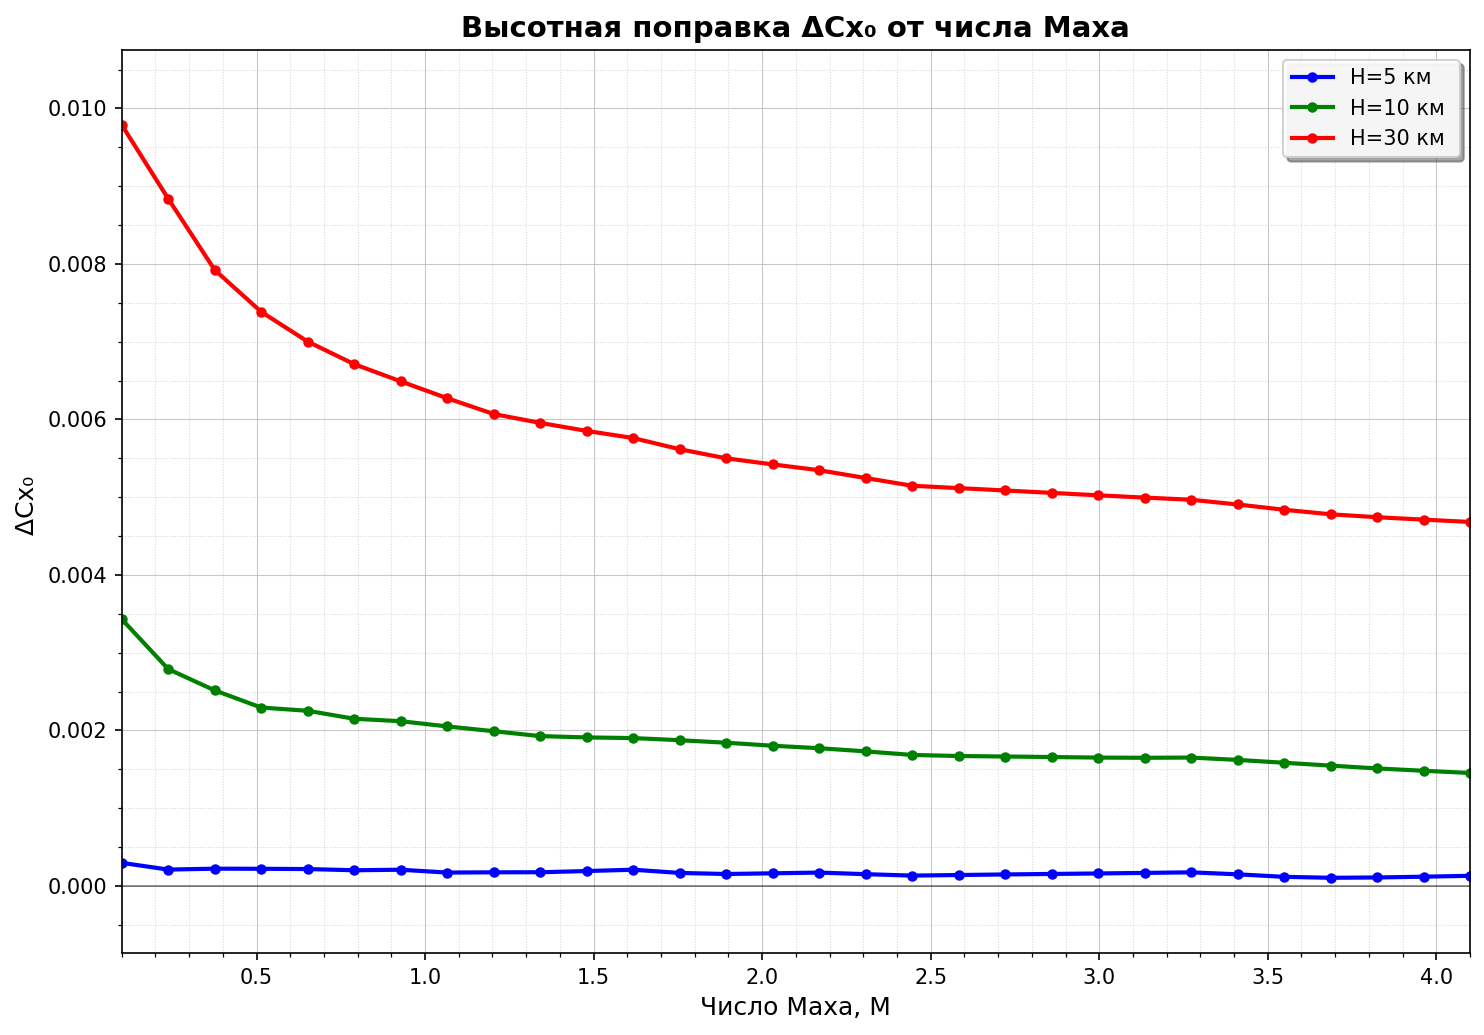


ТАБЛИЦА ВЫСОТНЫХ ПОПРАВОК ΔCx₀
------------------------------------------------------------
 0.10 |   0.000297 |   0.003432 |   0.009789 | 
 0.79 |   0.000202 |   0.002150 |   0.006711 | 
 1.48 |   0.000191 |   0.001910 |   0.005852 | 
 2.17 |   0.000172 |   0.001771 |   0.005347 | 
 2.86 |   0.000154 |   0.001658 |   0.005055 | 
 3.55 |   0.000117 |   0.001584 |   0.004839 | 
 4.10 |   0.000130 |   0.001453 |   0.004681 | 


In [11]:
# --- НОВЫЙ БЛОК: ВЫСОТНАЯ ПОПРАВКА ΔCx₀ от высоты и числа Маха ---
heights = [ 5000, 10000,30000]
speed_of_sound = [  336.4346, 299.5319,  295]



kinematic_viscosity = [ 1.5813e-05, 3.1957e-05, 0.00014] 
density = [ 1.1117, 0.4135,0.077] 
cen_mas = [2.242, 1.637, 1.559] #центры масс ЛА



# Параметры для расчёта
alphas = [0.1]  # малый угол атаки (близкий к нулю)
delta1s = [0]   # нулевое отклонение рулей
Mach_range = np.linspace(0.1, 4.1, 30)  # диапазон чисел Маха
height_indices = [0, 1, 2]  # индексы высот: 5000 м, 10000 м, 30000 м
heights_labels = ['H=5 км', 'H=10 км', 'H=30 км']
colors = ['blue', 'green', 'red']
x_cm = cen_mas[0]  # центр масс

# Массивы для хранения результатов
delta_cx0_results = []  # список массивов ΔCx₀ для каждой высоты

# Расчёт Cx₀ на нулевой высоте (условная "земля")
# Используем стандартные атмосферные условия на уровне моря:
c_sea = 340.3  # скорость звука на уровне моря, м/с
nyu_sea = 1.46e-5  # кинематическая вязкость на уровне моря, м²/с

cx0_sea = np.zeros_like(Mach_range)
for idx, M in enumerate(Mach_range):
    # Расчёт на нулевой высоте (условно)
    res_sea = calc(alpha=alphas[0], delta1=delta1s[0], M=M, 
                   a_sound=c_sea, nyu=nyu_sea, x_t=x_cm)
    cx0_sea[idx] = res_sea[4]  # Cx₀_F (пассивное)

# Расчёт Cx₀ на различных высотах и вычисление ΔCx₀
for h_idx in height_indices:
    h = heights[h_idx]
    c = speed_of_sound[h_idx]
    nyu = kinematic_viscosity[h_idx]
    
    cx0_h = np.zeros_like(Mach_range)
    delta_cx0 = np.zeros_like(Mach_range)
    
    for idx, M in enumerate(Mach_range):
        res_h = calc(alpha=alphas[0], delta1=delta1s[0], M=M, 
                     a_sound=c, nyu=nyu, x_t=x_cm)
        cx0_h[idx] = res_h[4]  # Cx₀_F на высоте h
        delta_cx0[idx] = cx0_h[idx] - cx0_sea[idx]  # ΔCx₀ = Cx₀(h) - Cx₀(0)
    
    delta_cx0_results.append(delta_cx0)

# Построение графика
fig = plt.figure(figsize=(10, 7), dpi=150)
ax = fig.add_subplot(111)

# Настройка внешнего вида
ax.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)
ax.set_title('Высотная поправка ΔCx₀ от числа Маха', fontsize=14, fontweight='bold')
ax.set_xlabel('Число Маха, M', fontsize=12)
ax.set_ylabel('ΔCx₀ ', fontsize=12)

# Построение кривых для разных высот
for i, h_idx in enumerate(height_indices):
    ax.plot(Mach_range, delta_cx0_results[i], 
            color=colors[i], linewidth=2, marker='o', markersize=4,
            label=f'{heights_labels[i]} ')

# Добавление горизонтальной линии на нуле
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

# Настройка легенды
ax.legend(loc='best', fontsize=10, framealpha=0.9, shadow=True)

# Настройка осей
ax.set_xlim([Mach_range[0], Mach_range[-1]])
# Автоматическое определение пределов по Y
y_min = min([min(delta) for delta in delta_cx0_results])
y_max = max([max(delta) for delta in delta_cx0_results])
y_margin = (y_max - y_min) * 0.1
ax.set_ylim([y_min - y_margin, y_max + y_margin])

# Добавление сетки
ax.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.7)
ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
ax.minorticks_on()


plt.tight_layout()
plt.show()

# Дополнительно: таблица значений для ключевых точек
print("\n" + "="*60)
print("ТАБЛИЦА ВЫСОТНЫХ ПОПРАВОК ΔCx₀")
print("="*60)
print("-"*60)

# Вывод значений для некоторых ключевых чисел Маха
key_mach_indices = [0, 5, 10, 15, 20, 25, 29]  # индексы ключевых точек
for idx in key_mach_indices:
    if idx < len(Mach_range):
        m_val = Mach_range[idx]
        row = f"{m_val:5.2f} | "
        for h_idx in height_indices:
            row += f"{delta_cx0_results[h_idx][idx]:10.6f} | "
        print(row)

print("="*60)